In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %matplotlib widget

In [4]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl

In [5]:
tqdm.pandas()

In [6]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 9
buffered = True
edges = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_drive_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
edges.tail(5)

,id,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,...,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector,geometry
14667,9678,891e2040c67ffff,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
14668,9679,891e2040c67ffff,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
14669,9680,891e204e093ffff,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
14670,9681,891e20462c3ffff,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."
14671,9682,891e20471d3ffff,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.12107 51.14465, 17.12089 51.144..."


In [7]:
hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON").set_index("h3_id")
hexagons.head(5)

,coordinates,parent,children,resolution,geometry
h3_id,,,,,
891e2045463ffff,"(51.09545580515501, 17.10268480221783)",881e204547fffff,"{'8a1e20454617fff', '8a1e20454627fff', '8a1e20...",9,"POLYGON ((17.10016 51.09622, 17.10019 51.09454..."
891e20456b3ffff,"(51.09256633045563, 17.090199278402874)",881e20456bfffff,"{'8a1e20456b27fff', '8a1e20456b37fff', '8a1e20...",9,"POLYGON ((17.08767 51.09333, 17.08771 51.09165..."
891e2041837ffff,"(51.06389906779957, 16.975441510431143)",881e204183fffff,"{'8a1e2041834ffff', '8a1e2041835ffff', '8a1e20...",9,"POLYGON ((16.97292 51.06466, 16.97295 51.06298..."
891e2042d23ffff,"(51.169360089031485, 17.04090812166009)",881e2042d3fffff,"{'8a1e2042d227fff', '8a1e2042d207fff', '8a1e20...",9,"POLYGON ((17.03838 51.17013, 17.03842 51.16845..."
891e2041d0bffff,"(51.07904535087956, 16.97510694306701)",881e2041d1fffff,"{'8a1e2041d0b7fff', '8a1e2041d0affff', '8a1e20...",9,"POLYGON ((16.97258 51.07981, 16.97262 51.07813..."


In [8]:
edges_shp = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, "shp_drive", f"edges_hex_{get_resolution_buffered_suffix(resolution, buffered)}.shp")).set_index("h3_id")

In [9]:
edges.columns

Index(['id', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2', 'lanes_3',
       'lanes_4', 'lanes_5', 'lanes_6',
       ...
       'width_24.5', 'width_25.5', 'width_26.5', 'width_27.5', 'width_28.5',
       'width_29.5', 'tunnel_building_passage', 'tunnel_yes',
       'tunnel_avalanche_protector', 'geometry'],
      dtype='object', length=130)

In [10]:
hex_feautres = edges.drop(columns="id").groupby(by="h3_id").sum()
hex_feautres

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,5,0,0,2,1,0,0,0,0,2,...,0,0,0,0,0,0,0,1,0,0
891e2040013ffff,4,2,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
891e2040017ffff,8,4,0,2,1,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
891e2040023ffff,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2040027ffff,8,5,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b73ffff,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b77ffff,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
hex_features_tfidf = tfidf(hex_feautres)
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,0.470615,0.000000,0.000000,0.300719,0.211734,0.0,0.0,0.0,0.0,0.436089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471141,0.0,0.0
891e2040013ffff,0.207013,0.196128,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.479564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2040017ffff,0.450436,0.426753,0.000000,0.179891,0.126659,0.0,0.0,0.0,0.0,0.391304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2040023ffff,0.522938,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2040027ffff,0.312260,0.369802,0.101102,0.249415,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,0.637404,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2055b73ffff,0.640997,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2055b77ffff,0.640997,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [24]:
embedding = reduce_umap(hex_features_tfidf, n_components=2, n_neighbors=7, metric="cosine")[0]

In [25]:
embedding["cluster"] = cluster_hdbscan(embedding, min_cluster_size=30, metric="euclidean")[0]
fig = px.scatter(embedding, x="x_0", y="x_1", color="cluster", width=800, height=700)
fig.show()

In [26]:
embedding.index = hex_feautres.index
embedding.head(5)

,x_0,x_1,cluster
h3_id,,,
891e2040007ffff,5.259202,13.626163,5
891e2040013ffff,4.723933,11.256835,5
891e2040017ffff,8.818051,7.149778,9
891e2040023ffff,12.062325,7.708409,9
891e2040027ffff,6.987530,6.215297,9


In [27]:
hexagons_clustered = hexagons.join(embedding).dropna()
hexagons_clustered.head(5)

,coordinates,parent,children,resolution,geometry,x_0,x_1,cluster
h3_id,,,,,,,,
891e20456b3ffff,"(51.09256633045563, 17.090199278402874)",881e20456bfffff,"{'8a1e20456b27fff', '8a1e20456b37fff', '8a1e20...",9,"POLYGON ((17.08767 51.09333, 17.08771 51.09165...",11.642821,-4.443547,2
891e2041837ffff,"(51.06389906779957, 16.975441510431143)",881e204183fffff,"{'8a1e2041834ffff', '8a1e2041835ffff', '8a1e20...",9,"POLYGON ((16.97292 51.06466, 16.97295 51.06298...",7.153909,4.671734,9
891e2041d0bffff,"(51.07904535087956, 16.97510694306701)",881e2041d1fffff,"{'8a1e2041d0b7fff', '8a1e2041d0affff', '8a1e20...",9,"POLYGON ((16.97258 51.07981, 16.97262 51.07813...",11.296673,5.844825,9
891e2041917ffff,"(51.06710228802962, 16.997936991090988)",881e204191fffff,"{'8a1e20419177fff', '8a1e2041916ffff', '8a1e20...",9,"POLYGON ((16.99541 51.06787, 16.99545 51.06619...",0.143240,8.333028,-1
891e20432abffff,"(51.11540773315221, 16.84385069938052)",881e20432bfffff,"{'8a1e20432a97fff', '8a1e20432a9ffff', '8a1e20...",9,"POLYGON ((16.84132 51.11617, 16.84136 51.11449...",15.387392,13.166211,-1


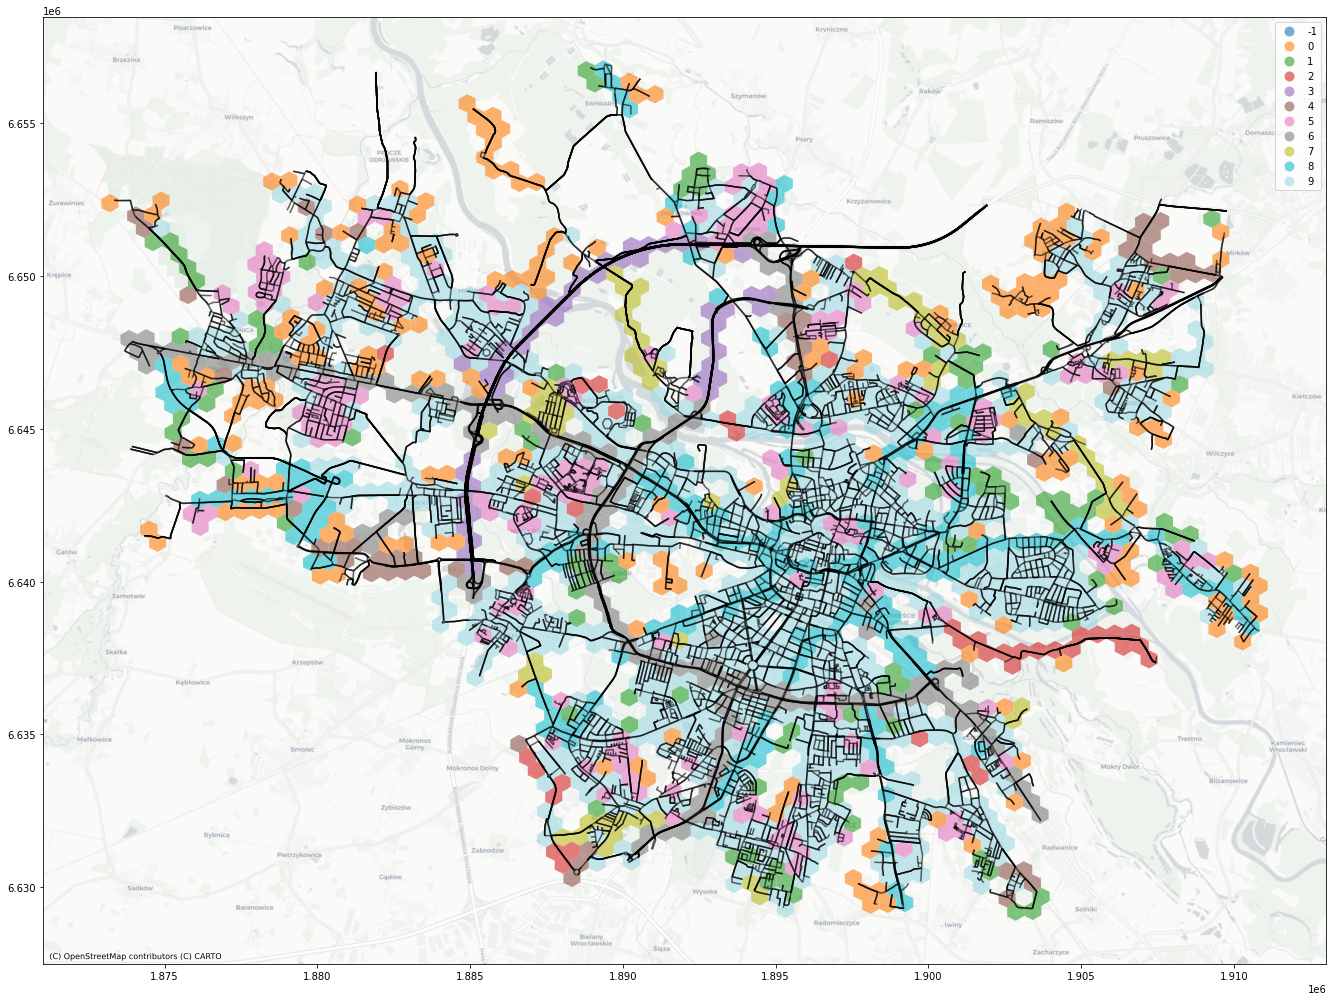

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(23, 21))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6, legend=True, cmap="tab20")
edges.to_crs(epsg=3857).plot(ax=ax, color="black", alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [29]:
hex_group_cluster = hex_features_tfidf.join(embedding).groupby(by="cluster")

In [30]:
hex_agg = hex_group_cluster.mean().reset_index()
hex_agg

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector,x_0,x_1
0,-1,0.304629,0.096644,0.030553,0.137913,0.078403,0.003754,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000669,0.032713,0.0,10.895138,6.787713
1,0,0.639273,0.001692,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,25.396942,-8.377064
2,1,0.456530,0.002070,0.000000,0.002431,0.002457,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-11.005946,-0.385615
3,2,0.318349,0.000000,0.324011,0.299282,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,10.005769,-5.963909
4,3,0.086759,0.241697,0.014080,0.110453,0.269893,0.228904,0.000000,0.000000,0.015216,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,23.160563,10.064490
5,4,0.300270,0.191668,0.012674,0.119429,0.056812,0.010127,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-2.327181,10.297348
6,5,0.421796,0.064571,0.022903,0.077767,0.014575,0.004533,0.000506,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.012272,0.006146,0.0,5.293710,12.653027
7,6,0.194170,0.269965,0.067764,0.266671,0.137613,0.060153,0.012526,0.000000,0.000658,...,0.0,0.0,0.0,0.0,0.0,0.008746,0.002223,0.0,17.654791,5.968439
8,7,0.375383,0.036746,0.017314,0.165423,0.050944,0.006819,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,3.099741,6.923751
9,8,0.280921,0.279070,0.065610,0.210655,0.128118,0.090847,0.010261,0.002044,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.003059,0.002587,0.0,5.147980,1.529226


In [33]:
fig = px.bar(hex_agg, x="cluster", y=list(filter(lambda x: "bridge" in x, hex_agg.columns)), width=1300)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
    )
)
fig.show()

In [32]:
from src.tools.feature_extraction import melt_and_max

for column_name in ["oneway", "lanes", "maxspeed", "width"]:
    columns = [x for x in edges.columns if column_name in x]
    edges = edges.join(melt_and_max(edges, column_name, columns), on="id")
edges

IndexError: list index out of range